# Twitter 16

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

tweetSet='twitter16'
# Define the path to your text file
#file_path = './Data/twitter16/label.txt'
file_path = './Data/'+tweetSet+'/source_tweets.txt'

tweet_ids = []
tweet_texts = []

# Open and read the file line by line
with open(file_path, 'r', encoding="utf-8") as file:
    for line in file:
        line = line.strip()  # Remove any whitespace
        if '\t' in line:  # Ensure there's a tab before splitting
            parts = line.split('\t', 1)  # Split at the first tab only
            tweet_ids.append(parts[0])
            tweet_texts.append(parts[1])

# Convert to DataFrame
df = pd.DataFrame({"TweetID": tweet_ids, "TweetText": tweet_texts})
df.dropna()
df

,TweetID,TweetText
0,656955120626880512,correct predictions in back to the future ii URL
1,615689290706595840,.@whitehouse in rainbow colors for #scotusmarr...
2,613404935003217920,cops bought the alleged church shooter burger ...
3,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...
4,714598641827246081,an open letter to trump voters from his top st...
...,...,...
813,693546915892428800,jeb bush campaign kicks off 3-state farewell t...
814,544269749405097984,breaking: live coverage of hostage situation u...
815,760109079133990912,“after school satan clubs”? URL
816,779633844680962048,this network of tunnels is from the stone age ...


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

tweetSet='twitter16'
# Define the path to your text file
#file_path = './Data/twitter16/label.txt'
file_path = './Data/'+tweetSet+'/label.txt'

# Initialize empty lists to store the data
labels = []
values = []

# Read the file line by line and extract the data
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()  # Remove any leading/trailing whitespace
        label, value = line.split(':')  # Split the line into label and value
        labels.append(label)
        values.append(int(value))  # Convert the value to an integer

# Create a DataFrame from the lists
df_label = pd.DataFrame({'Label': labels, 'TweetID': values})
df_label["TweetID"]=df_label["TweetID"].astype(str)
# Optionally, you can filter the DataFrame based on specific labels:
#df_filtered = df[df['Label'].isin(['true', 'false'])]
df_label = df_label[df_label['Label'].isin([ 'false'])]
df_filtered =df_label.copy()

df_filtered['Label'] = df_label['Label'].str.lower().replace({'true': True, 'false': False})

distinct_labels = df_label['Label'].unique()
print(distinct_labels)

# Display the DataFrame
df_filtered


['false']


,Label,TweetID
0,False,656955120626880512
2,False,613404935003217920
9,False,622891631293935616
14,False,622858454949040128
15,False,656870311057575936
...,...,...
586,False,623818627054206977
590,False,667465205258051584
593,False,647169726158925824
596,False,631388553801564160


In [3]:
df_merge=df_filtered.merge(df,on="TweetID",how="inner")
df_merge

,Label,TweetID,TweetText
0,False,656955120626880512,correct predictions in back to the future ii URL
1,False,613404935003217920,cops bought the alleged church shooter burger ...
2,False,622891631293935616,#wakeupamerica🇺🇸 who needs a #gun registry whe...
3,False,622858454949040128,in heaven chick-fil-a is open on sundays.
4,False,656870311057575936,the 5 most accurate predictions from the decad...
...,...,...,...
200,False,623818627054206977,nasa confirms earth will experience 15 days of...
201,False,667465205258051584,remember the man who killed four marines in ch...
202,False,647169726158925824,poll: @hillaryclinton trails @berniesanders in...
203,False,631388553801564160,did a real life 'fallen angel' just fall from ...


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np

In [5]:
def initializeModel():
    # load model and tokenizer
    roberta = "cardiffnlp/twitter-roberta-base-sentiment"
    model = AutoModelForSequenceClassification.from_pretrained(roberta)
    tokenizer = AutoTokenizer.from_pretrained(roberta)
    return tuple([model,tokenizer])


In [6]:
def getClassification(model, tokenizer,tweet):
    # pre-process tweet and get rid of any @mention and url http
    tweet_words = []
#     print(tweet)
    for word in tweet.split(' '):
        if word.startswith('@') and len(word) > 1:
            word = '@user'

        elif word.startswith('http'):
            word = "http"
        tweet_words.append(word)

    tweet_proc = " ".join(tweet_words)
    labels = ['Negative', 'Neutral', 'Positive']
    encoded_tweet = tokenizer(tweet_proc, return_tensors='pt')
    output = model(**encoded_tweet)

    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

#     for i in range(len(scores)):

#         l = labels[i]
#         s = scores[i]
#         print(l,s)

    # Apply the softmax function to the class scores
    probs = np.exp(scores) / np.sum(np.exp(scores))

    # Get the index of the class with the highest probability
    max_index = np.argmax(probs)

    # Get the label of the class with the highest probability
    max_label = labels[max_index]
    return max_label

In [7]:
result= initializeModel()
model =result[0] 
tokenizer=result[1]

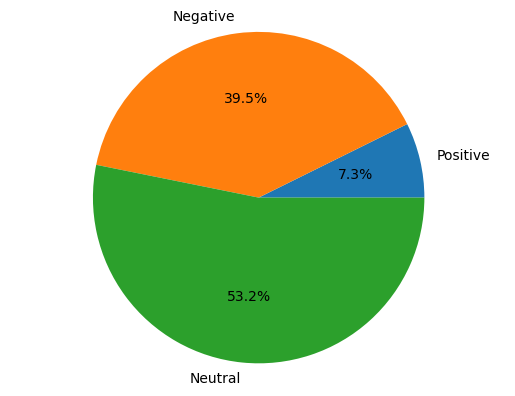

In [8]:
# Read the Excel sheet into a DataFrame
# dfReal = pd.read_csv("NewsRealCOVID-19.csv")
positive_count = 0
negative_count = 0
neutral_count = 0

# Iterate over the rows of the DataFrame
for index, row in df_merge.iterrows():
    label=getClassification(model,tokenizer,row["TweetText"])
    df_merge.at[index, "label"] = label
    if label=="Neutral":
        neutral_count +=1    
    elif label=="Negative":
        negative_count +=1
    elif label=="Positive": 
        positive_count +=1
    # Classify the text in the "comment" column
#     output = sentiment_analysis(row["title"], max_length=128)[0]
#     score = output['score']
#     label = output["label"]
#     dfRealAndFake.at[index, "score"] = score
#     dfRealAndFake.at[index, "label"] = label
    

# Create a list of the counts for each class
counts = [positive_count, negative_count, neutral_count]

# Create a list of the labels for each class
labels = ["Positive", "Negative", "Neutral"]

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')
ax.axis("equal")

# Display the pie chart
plt.show()

# Emotional Analyses Twitter 16

In [9]:
def initializeModelImotion():
    # load model and tokenizer
    roberta = "bhadresh-savani/bert-base-uncased-emotion"
    model = AutoModelForSequenceClassification.from_pretrained(roberta)
    tokenizer = AutoTokenizer.from_pretrained(roberta)
    return tuple([model,tokenizer])

In [10]:
def getClassificationImotion(model, tokenizer,tweet):
    # pre-process tweet and get rid of any @mention and url http
    tweet_words = []
#     print(tweet)
    for word in tweet.split(' '):
        if word.startswith('@') and len(word) > 1:
            word = '@user'

        elif word.startswith('http'):
            word = "http"
        tweet_words.append(word)

    tweet_proc = " ".join(tweet_words)
    labels = ['sadness', 'joy', 'love' ,'anger','fear' , 'surprise']
    encoded_tweet = tokenizer(tweet_proc, return_tensors='pt')
    output = model(**encoded_tweet)

    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

#     for i in range(len(scores)):

#         l = labels[i]
#         s = scores[i]
#         print(l,s)

    # Apply the softmax function to the class scores
    probs = np.exp(scores) / np.sum(np.exp(scores))

    # Get the index of the class with the highest probability
    max_index = np.argmax(probs)

    # Get the label of the class with the highest probability
    max_label = labels[max_index]
    return max_label

In [11]:
result= initializeModelImotion()
model =result[0] 
tokenizer=result[1]

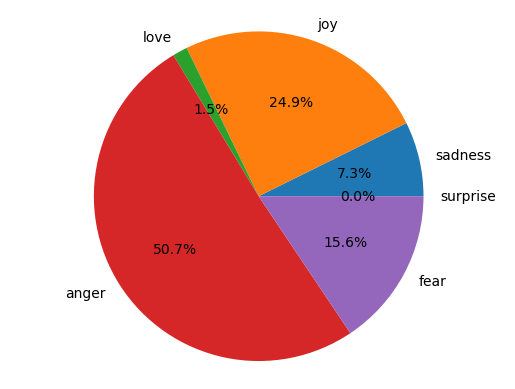

In [12]:
sadness_count = 0
joy_count = 0
love_count = 0
anger_count=0
fear_count=0
surprise_count=0
# Iterate over the rows of the DataFrame
for index, row in df_merge.iterrows():
    label=getClassificationImotion(model,tokenizer,row["TweetText"])
    df_merge.at[index, "label"] = label
    if label=="sadness":
        sadness_count +=1    
    elif label=="joy":
        joy_count +=1
    elif label=="love": 
        love_count +=1
    elif label=="anger": 
        anger_count +=1
    elif label=="fear": 
        fear_count +=1
    elif label=="surprise": 
        surprise_count +=1
        
    # Classify the text in the "comment" column
#     output = sentiment_analysis(row["title"], max_length=128)[0]
#     score = output['score']
#     label = output["label"]
#     dfRealAndFake.at[index, "score"] = score
#     dfRealAndFake.at[index, "label"] = label
    

# Create a list of the counts for each class
counts = [sadness_count, joy_count, love_count,anger_count , fear_count , surprise_count]

# Create a list of the labels for each class
labels = ['sadness', 'joy', 'love' ,'anger','fear' , 'surprise']

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')
ax.axis("equal")

# Display the pie chart
plt.show()
# data = dfRealAndFakeContent["label"]

# # Create the pie chart
# plt.pie(data)
# plt.show()

# Twitter 15

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

tweetSet='twitter15'
# Define the path to your text file
#file_path = './Data/twitter16/label.txt'
file_path = './Data/'+tweetSet+'/source_tweets.txt'

tweet_ids = []
tweet_texts = []

# Open and read the file line by line
with open(file_path, 'r', encoding="utf-8") as file:
    for line in file:
        line = line.strip()  # Remove any whitespace
        if '\t' in line:  # Ensure there's a tab before splitting
            parts = line.split('\t', 1)  # Split at the first tab only
            tweet_ids.append(parts[0])
            tweet_texts.append(parts[1])

# Convert to DataFrame
df = pd.DataFrame({"TweetID": tweet_ids, "TweetText": tweet_texts})
df.dropna()
df

,TweetID,TweetText
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...
1,714598641827246081,an open letter to trump voters from his top st...
2,691809004356501505,"""america is a nation of second chances"" —@potu..."
3,693204708933160960,"brandon marshall visits and offers advice, sup..."
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...
...,...,...
1485,692004901455556608,.@potus just announced new reforms to address ...
1486,760109079133990912,“after school satan clubs”? URL
1487,500281131057811456,breaking news: according to documents released...
1488,523098334421319680,ebola vaccines? URL #news #today


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

tweetSet='twitter15'
# Define the path to your text file
#file_path = './Data/twitter16/label.txt'
file_path = './Data/'+tweetSet+'/label.txt'

# Initialize empty lists to store the data
labels = []
values = []

# Read the file line by line and extract the data
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()  # Remove any leading/trailing whitespace
        label, value = line.split(':')  # Split the line into label and value
        labels.append(label)
        values.append(int(value))  # Convert the value to an integer

# Create a DataFrame from the lists
df_label = pd.DataFrame({'Label': labels, 'TweetID': values})
df_label["TweetID"]=df_label["TweetID"].astype(str)
# Optionally, you can filter the DataFrame based on specific labels:
#df_filtered = df[df['Label'].isin(['true', 'false'])]
df_label = df_label[df_label['Label'].isin([ 'false'])]
df_filtered =df_label.copy()

df_filtered['Label'] = df_label['Label'].str.lower().replace({'true': True, 'false': False})

distinct_labels = df_label['Label'].unique()
print(distinct_labels)

# Display the DataFrame
df_filtered


['false']


,Label,TweetID
9,False,495366618818830336
10,False,532206910796468224
11,False,560187970389819392
12,False,531568534066057217
13,False,489829414704648192
...,...,...
1461,False,540333359793451008
1462,False,514495841600811009
1467,False,534445263528947712
1475,False,519868410599993344


In [15]:
df_merge=df_filtered.merge(df,on="TweetID",how="inner")
df_merge

,Label,TweetID,TweetText
0,False,495366618818830336,#riphulkhogan my heart is ripping like your sh...
1,False,532206910796468224,a chick-fil-a manager allegedly banned this hi...
2,False,560187970389819392,islamic tribunal using sharia law in texas has...
3,False,531568534066057217,alpha male rt @marc_leibowitz: photo of vladim...
4,False,489829414704648192,เผยกบฏยูเครนอาจเข้าใจผิดคิดว่า #mh17 เป็นเครื่...
...,...,...,...
365,False,540333359793451008,obama's daughter is pregnant lol michelle shou...
366,False,514495841600811009,iphone 6 owners claim it's bending in their po...
367,False,534445263528947712,missouri governor declares state of emergency ...
368,False,519868410599993344,thumbs up emoji rt @complexmag someone spray p...


In [16]:
result= initializeModel()
model =result[0] 
tokenizer=result[1]

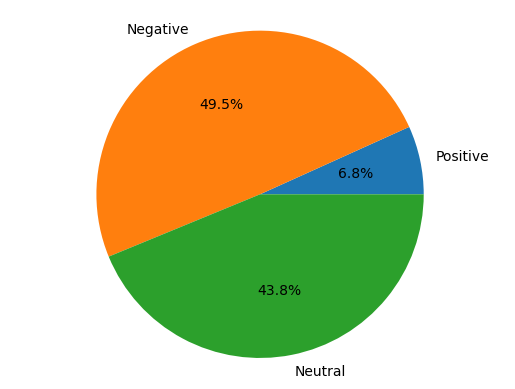

In [17]:
# Read the Excel sheet into a DataFrame
# dfReal = pd.read_csv("NewsRealCOVID-19.csv")
positive_count = 0
negative_count = 0
neutral_count = 0

# Iterate over the rows of the DataFrame
for index, row in df_merge.iterrows():
    label=getClassification(model,tokenizer,row["TweetText"])
    df_merge.at[index, "label"] = label
    if label=="Neutral":
        neutral_count +=1    
    elif label=="Negative":
        negative_count +=1
    elif label=="Positive": 
        positive_count +=1
    # Classify the text in the "comment" column
#     output = sentiment_analysis(row["title"], max_length=128)[0]
#     score = output['score']
#     label = output["label"]
#     dfRealAndFake.at[index, "score"] = score
#     dfRealAndFake.at[index, "label"] = label
    

# Create a list of the counts for each class
counts = [positive_count, negative_count, neutral_count]

# Create a list of the labels for each class
labels = ["Positive", "Negative", "Neutral"]

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')
ax.axis("equal")

# Display the pie chart
plt.show()

In [18]:
result= initializeModelImotion()
model =result[0] 
tokenizer=result[1]

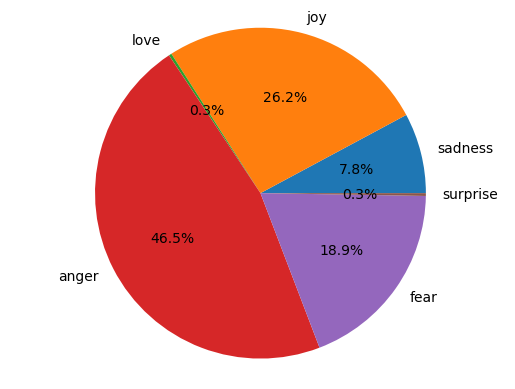

In [19]:
sadness_count = 0
joy_count = 0
love_count = 0
anger_count=0
fear_count=0
surprise_count=0
# Iterate over the rows of the DataFrame
for index, row in df_merge.iterrows():
    label=getClassificationImotion(model,tokenizer,row["TweetText"])
    df_merge.at[index, "label"] = label
    if label=="sadness":
        sadness_count +=1    
    elif label=="joy":
        joy_count +=1
    elif label=="love": 
        love_count +=1
    elif label=="anger": 
        anger_count +=1
    elif label=="fear": 
        fear_count +=1
    elif label=="surprise": 
        surprise_count +=1
        
    # Classify the text in the "comment" column
#     output = sentiment_analysis(row["title"], max_length=128)[0]
#     score = output['score']
#     label = output["label"]
#     dfRealAndFake.at[index, "score"] = score
#     dfRealAndFake.at[index, "label"] = label
    

# Create a list of the counts for each class
counts = [sadness_count, joy_count, love_count,anger_count , fear_count , surprise_count]

# Create a list of the labels for each class
labels = ['sadness', 'joy', 'love' ,'anger','fear' , 'surprise']

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')
ax.axis("equal")

# Display the pie chart
plt.show()
# data = dfRealAndFakeContent["label"]

# # Create the pie chart
# plt.pie(data)
# plt.show()

# PHEME

In [23]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
 
def get_created_at(json_path):
    if os.path.exists(json_path):
        with open(json_path, "r") as file:
            data = json.load(file)
        return data['created_at'] #data.get("created_at", None)
    else:
        return None
 

In [24]:
"""
Python 3 function to convert rumour annotations into True, False, Unverified
"""

def convert_annotations(annotation, string = True):
    if 'misinformation' in annotation.keys() and 'true'in annotation.keys():
        if int(annotation['misinformation'])==0 and int(annotation['true'])==0:
            if string:
                label = "unverified"
            else:
                label = 2
        elif int(annotation['misinformation'])==0 and int(annotation['true'])==1 :
            if string:
                label = "true"
            else:
                label = 1
        elif int(annotation['misinformation'])==1 and int(annotation['true'])==0 :
            if string:
                label = "false"
            else:
                label = 0
        elif int(annotation['misinformation'])==1 and int(annotation['true'])==1:
            print ("OMG! They both are 1!")
            print(annotation['misinformation'])
            print(annotation['true'])
            label = None
            
    elif 'misinformation' in annotation.keys() and 'true' not in annotation.keys():
        # all instances have misinfo label but don't have true label
        if int(annotation['misinformation'])==0:
            if string:
                label = "unverified"
            else:
                label = 2
        elif int(annotation['misinformation'])==1:
            if string:
                label = "false"
            else:
                label = 0
                
    elif 'true' in annotation.keys() and 'misinformation' not in annotation.keys():
        #print ('Has true not misinformation')
        label = None
    else:
        #print('No annotations')
        label = None
           
    return label


In [25]:
import os
# Create a DataFrame from the lists
df = pd.DataFrame(columns=['TweetID', 'IsRumour', 'IsTrue','Path','CreatedAt','RootFollowerCount'])
df
count=0
Incidentdirectory = './Data/PHEME_veracity/all-rnr-annotated-threads/'
for subdirectoryIncident in os.listdir(Incidentdirectory):
    subdirectoryIncident_path = os.path.join(Incidentdirectory, subdirectoryIncident)
    if os.path.isdir(subdirectoryIncident_path):
        rmourOrnonrumour=['rumours','non-rumours']
        for rumourLabel in rmourOrnonrumour:
            directory =subdirectoryIncident_path+'/'+rumourLabel
            #directory = './Data/PHEME_veracity/all-rnr-annotated-threads/ottawashooting-all-rnr-threads/'+rumourLabel
            for subdirectory in os.listdir(directory):
                    subdirectory_path = os.path.join(directory, subdirectory)
                    if os.path.isdir(subdirectory_path):
                        count=count+1
                        #print("Subdirectory: ",count, subdirectory_path )
                        # Open and read the JSON file
                        file_path=subdirectory_path+'/annotation.json'
                        with open(file_path, 'r') as file:
                            data = json.load(file)
                            my_dict = {}
                            for key, value in data.items():
                                my_dict[key] = value
                            

                            # Create a dictionary with the data for the new row
                            new_row_data = {
                                'TweetID': subdirectory,
                                'IsRumour':  my_dict['is_rumour'],
                                'IsTrue':convert_annotations(my_dict) ,#'true' if my_dict['is_rumour']=='nonrumour' else convert_annotations(my_dict) ,
                                'Path':subdirectory_path
                            }
                            # Convert the dictionary to a DataFrame
                            new_row_df = pd.DataFrame(new_row_data, index=[0])
                            # Concatenate the new row DataFrame with the original DataFrame
                            df = pd.concat([df, new_row_df], ignore_index=True)
df

,TweetID,IsRumour,IsTrue,Path,CreatedAt,RootFollowerCount
0,552783238415265792,rumour,true,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
1,552783667052167168,rumour,true,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
2,552783745565347840,rumour,true,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
3,552784168849907712,rumour,true,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
4,552784526955806720,rumour,true,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
...,...,...,...,...,...,...
6420,544521260840267776,nonrumour,None,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
6421,544521433473634304,nonrumour,None,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
6422,544521788777304064,nonrumour,None,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
6423,544521880661950464,nonrumour,None,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN


In [26]:
# Get the value counts of 'IsTrue'
value_counts = df['IsTrue'].value_counts()

print("Value Counts of 'IsTrue':")
print(value_counts)

Value Counts of 'IsTrue':
true          1067
unverified     697
false          638
Name: IsTrue, dtype: int64


In [27]:
#Take Only False Tweets
df[df['IsTrue'].isin(['true','false'])]['IsTrue'].unique()
df[df['IsTrue'].isin(['true','false'])]['IsTrue'].value_counts()
df=df[df['IsTrue'].isin(['false'])]
#df['IsTrue'] = df['IsTrue'].str.lower().replace({'true': True, 'false': False})
# Convert 'IsTrue' column to boolean
#df['IsTrue'] = df['IsTrue'].map({'true': True, 'false': False})
df = df.reset_index(drop=True)
df

,TweetID,IsRumour,IsTrue,Path,CreatedAt,RootFollowerCount
0,552801880812691456,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
1,552805267990413312,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
2,552806309540528128,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
3,552807027781947393,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
4,552807210041212928,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
...,...,...,...,...,...,...
633,544407300329709568,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
634,544443739800731648,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
635,544446282559799296,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN
636,544451181754744832,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN


In [28]:
from datetime import datetime
df["TweetText"]=""
# # Iterate through the DataFrame and add Created At
for index, row in df.iterrows(): # df[:1000].iterrows(): 
# for index, row in   df[:10].iterrows():     
    #fileName=df.iloc[index]['Path']+'/structure.json'
    file_path_sourceTweet=df.iloc[index]['Path']+'/source-tweets/'+df.iloc[index]['TweetID']+'.json'
    with open(file_path_sourceTweet, 'r') as fileSource:
        data_Source = json.load(fileSource)
    # Extract the value of the 'created_at' field 
    TweetText  = data_Source['text']
#     print(TweetText)

    df.loc[index,'TweetText']=TweetText
df

,TweetID,IsRumour,IsTrue,Path,CreatedAt,RootFollowerCount,TweetText
0,552801880812691456,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN,Cartoonist Stephane Charbonnier was critically...
1,552805267990413312,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN,Cartoonists Cabu and Charb died in the attack ...
2,552806309540528128,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN,“@LePoint: #CharlieHebdo : “The cartoonists Ch...
3,552807027781947393,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN,Photo of the 2 cartoonists killed in the attac...
4,552807210041212928,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN,#CharlieHebdo liveblog by @Independent says ne...
...,...,...,...,...,...,...,...
633,544407300329709568,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN,"An #ISIS ""lonewolf"" has taken around 30 people..."
634,544443739800731648,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN,I hope for everyones sake that this is fake bu...
635,544446282559799296,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN,please repost this and stay out of Sydney on N...
636,544451181754744832,rumour,false,./Data/PHEME_veracity/all-rnr-annotated-thread...,NaN,NaN,#sydneysiege: Up to 20 hostages are being held...


In [29]:
result= initializeModel()
model =result[0] 
tokenizer=result[1]

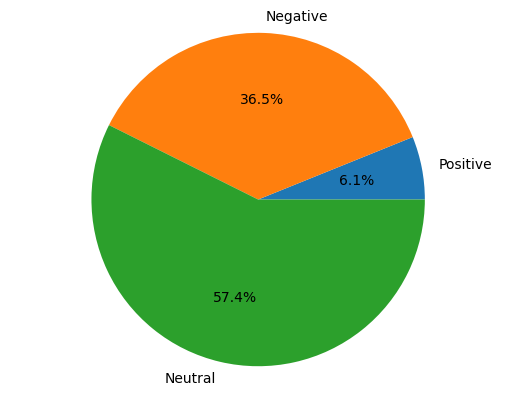

In [30]:
# Read the Excel sheet into a DataFrame
# dfReal = pd.read_csv("NewsRealCOVID-19.csv")
positive_count = 0
negative_count = 0
neutral_count = 0

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    label=getClassification(model,tokenizer,row["TweetText"])
    df.at[index, "label"] = label
    if label=="Neutral":
        neutral_count +=1    
    elif label=="Negative":
        negative_count +=1
    elif label=="Positive": 
        positive_count +=1
    # Classify the text in the "comment" column
#     output = sentiment_analysis(row["title"], max_length=128)[0]
#     score = output['score']
#     label = output["label"]
#     dfRealAndFake.at[index, "score"] = score
#     dfRealAndFake.at[index, "label"] = label
    

# Create a list of the counts for each class
counts = [positive_count, negative_count, neutral_count]

# Create a list of the labels for each class
labels = ["Positive", "Negative", "Neutral"]

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')
ax.axis("equal")

# Display the pie chart
plt.show()

In [31]:
result= initializeModelImotion()
model =result[0] 
tokenizer=result[1]

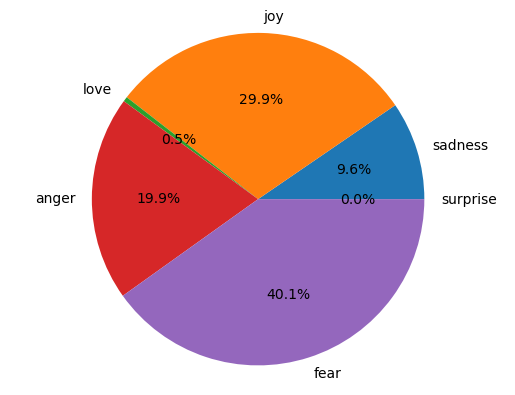

In [32]:
sadness_count = 0
joy_count = 0
love_count = 0
anger_count=0
fear_count=0
surprise_count=0
# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    label=getClassificationImotion(model,tokenizer,row["TweetText"])
    df.at[index, "label"] = label
    if label=="sadness":
        sadness_count +=1    
    elif label=="joy":
        joy_count +=1
    elif label=="love": 
        love_count +=1
    elif label=="anger": 
        anger_count +=1
    elif label=="fear": 
        fear_count +=1
    elif label=="surprise": 
        surprise_count +=1
        
    # Classify the text in the "comment" column
#     output = sentiment_analysis(row["title"], max_length=128)[0]
#     score = output['score']
#     label = output["label"]
#     dfRealAndFake.at[index, "score"] = score
#     dfRealAndFake.at[index, "label"] = label
    

# Create a list of the counts for each class
counts = [sadness_count, joy_count, love_count,anger_count , fear_count , surprise_count]

# Create a list of the labels for each class
labels = ['sadness', 'joy', 'love' ,'anger','fear' , 'surprise']

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')
ax.axis("equal")

# Display the pie chart
plt.show()
# data = dfRealAndFakeContent["label"]

# # Create the pie chart
# plt.pie(data)
# plt.show()